In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

In [ ]:
!git clone http://github.com/sciserver/SciScript-Python.git

Cloning into 'SciScript-Python'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 1217 (delta 29), reused 44 (delta 22), pack-reused 1161
Receiving objects: 100% (1217/1217), 369.85 KiB | 657.00 KiB/s, done.
Resolving deltas: 100% (694/694), done.


In [ ]:
import sys
sys.path.append('/content/SciScript-Python/py3')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import model_processes as mp
#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from tensorflow import keras
import tensorflow as tf

In [ ]:
df_train = mp.frame_from_drive('AllStarsSampled')
df_test = mp.frame_from_drive('AllStarsSampledTest')
X_train, y_train = df_train.iloc[:,1:].sort_index(axis=1), df_train.iloc[:,0]
X_test, y_test = df_test.iloc[:,1:].sort_index(axis=1), df_test.iloc[:,0]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  stratify=y_train,
                                                  random_state=25)

In [ ]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)

In [ ]:
y_train.columns

Index(['A', 'CV', 'CarbonWD', 'F', 'G', 'K', 'LT', 'M', 'OB'], dtype='object')

In [ ]:
class_names = list(y_train.columns)
class_names[2] = 'C/WD'

In [ ]:
tf.one_hot(tf.constant([2, 3, 4]),depth=5)

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [ ]:
class BalancedSparseAccuracy(keras.metrics.Metric):
    def __init__(self, name="balanced_sparse_accuracy", **kwargs):
        super(BalancedSparseAccuracy, self).__init__(name=name, **kwargs)
        self.accuracies = self.add_weight(name="balanced_accuracy", 
                                          shape=(9,),
                                          initializer="zeros")
        self.sample_count = self.add_weight(name="sample_count", 
                                          shape=(9,),
                                       initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=1), depth=9)
        correct = (tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")) & \
                    tf.not_equal(y_true, 0)
        correct = tf.cast(correct, "float32") 
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            correct = tf.multiply(correct, sample_weight)
            y_true = tf.multiply(y_true, sample_weight)
        correct = tf.reduce_sum(correct, 0)
        self.accuracies.assign_add(correct)
        counts = tf.cast(tf.reduce_sum(y_true, 0), "float32")
        self.sample_count.assign_add(counts)

    def result(self):
        class_acc = self.accuracies / self.sample_count
        return tf.reduce_mean(class_acc)

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.accuracies.assign(tf.zeros((9,)))
        self.sample_count.assign(tf.zeros((9,)))


In [ ]:
X_train.shape

(72000, 340)

In [ ]:
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      BalancedSparseAccuracy(name='balanced_acc'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          255, activation='relu',
          input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(170, activation='relu'),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(80, activation='relu'),
      keras.layers.Dense(9, activation='softmax',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=5e-3, epsilon=1e-8),
      loss=keras.losses.CategoricalCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
EPOCHS = 200
BATCH_SIZE = 2048

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_balanced_acc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()

In [ ]:
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val))

Epoch 1/200
36/36 [==============================] - 2s 63ms/step - loss: 1.6749 - accuracy: 0.5431 - balanced_acc: 0.5571 - precision: 0.6505 - recall: 0.4131 - val_loss: 0.7260 - val_accuracy: 0.7454 - val_balanced_acc: 0.7935 - val_precision: 0.8415 - val_recall: 0.6054
Epoch 2/200
36/36 [==============================] - 2s 47ms/step - loss: 0.7671 - accuracy: 0.7248 - balanced_acc: 0.7493 - precision: 0.8049 - recall: 0.6234 - val_loss: 0.5938 - val_accuracy: 0.7938 - val_balanced_acc: 0.8401 - val_precision: 0.8670 - val_recall: 0.6948
Epoch 3/200
36/36 [==============================] - 2s 49ms/step - loss: 0.6697 - accuracy: 0.7620 - balanced_acc: 0.7748 - precision: 0.8264 - recall: 0.6828 - val_loss: 0.5444 - val_accuracy: 0.8107 - val_balanced_acc: 0.8567 - val_precision: 0.8744 - val_recall: 0.7293
Epoch 4/200
36/36 [==============================] - 2s 48ms/step - loss: 0.6129 - accuracy: 0.7840 - balanced_acc: 0.7987 - precision: 0.8405 - recall: 0.7152 - val_loss: 0.5134

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics =  ['loss', 'precision', 'recall', 'balanced_acc']
  plt.figure(figsize=(12, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

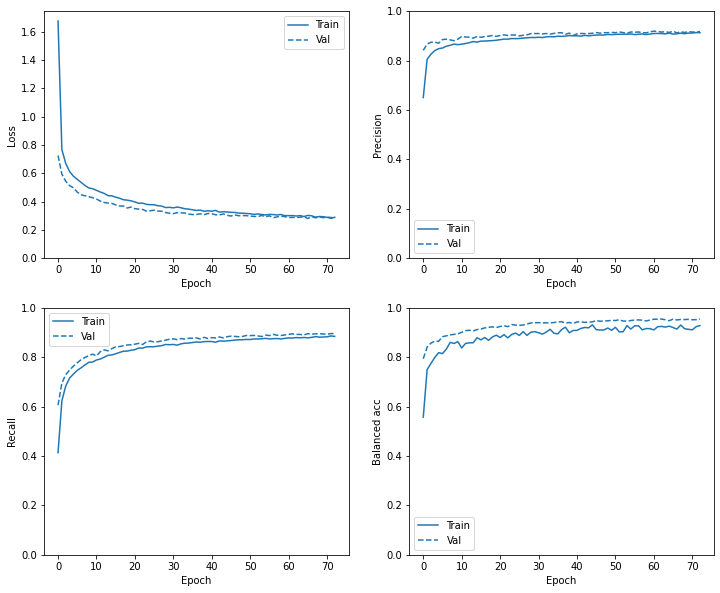

In [ ]:
plot_metrics(baseline_history)

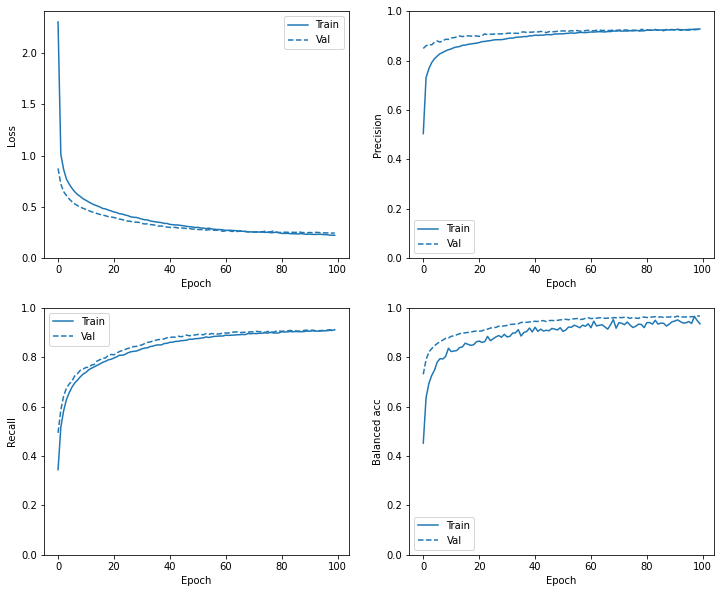

In [ ]:
plot_metrics(baseline_history) #eps 5e-9

In [ ]:
train_predictions = model.predict(X_train, batch_size=BATCH_SIZE)
# train_predictions = tf.argmax(train_predictions, axis=1).numpy()

test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)
# test_predictions = tf.argmax(test_predictions, axis=1).numpy()

In [ ]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)

loss :  0.40377846360206604
accuracy :  0.8383347392082214
balanced_acc :  2.2299609184265137
precision :  0.8517558574676514
recall :  0.8272925615310669


In [ ]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)


loss :  0.3677197992801666
accuracy :  0.8400797247886658
balanced_acc :  2.2576351165771484
precision :  0.8564454317092896
recall :  0.8280172944068909


In [ ]:
@np.vectorize
def label_if_not_0(num):
    if num < 20:
        return ' '
    else:
        return f'{num}%'

In [ ]:
def plot_cm(labels, predictions, class_names=class_names):
    pred = np.argmax(predictions, axis=1)
    labels = np.argmax(labels, axis=1)
    cm = confusion_matrix(labels, pred, normalize='true') * 100
    annot = label_if_not_0(cm.astype(int))
    df_cf = pd.DataFrame(cm.astype(int), index=class_names, columns=class_names)
    fig = plt.figure(figsize=(10,8), facecolor='#8a8bbf')
    heatmap = sns.heatmap(df_cf, annot=annot, fmt= '', cmap='BuPu', 
                        cbar_kws={'format':'%.0f%%'}, annot_kws={'size':16})
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha='right', fontsize=16)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16)
    heatmap.set_ylabel('Actual class', fontsize=20, labelpad=-9)
    heatmap.set_xlabel('Predicted class', fontsize=20, labelpad=10)
    heatmap.set_title('Model Classifications (% of Actual)', fontsize=22)
    # plt.savefig('Labels_classified.png', facecolor='#8a8bbf')

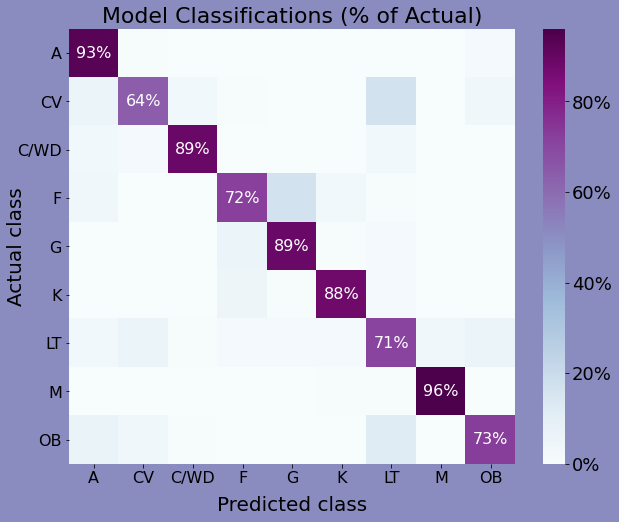

In [ ]:
plot_cm(y_test.values, test_predictions)

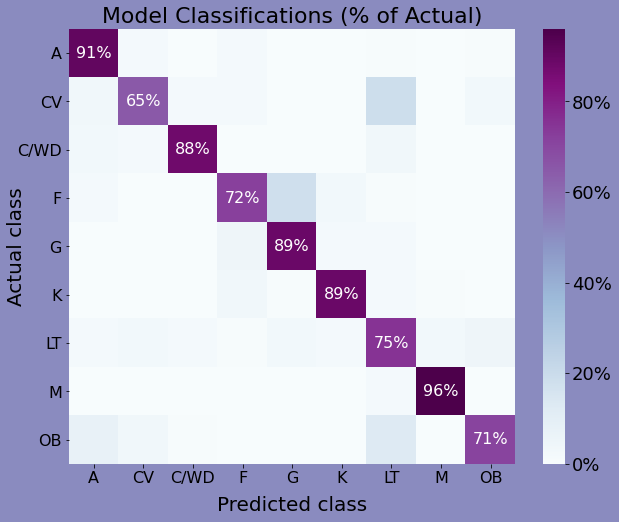

In [ ]:
plot_cm(y_test.values, test_predictions) 

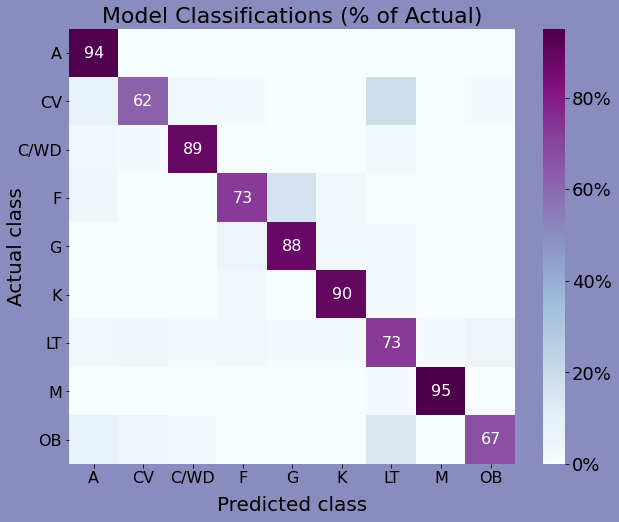

In [ ]:
plot_cm(y_test.values, test_predictions) #dropout layer 0.7

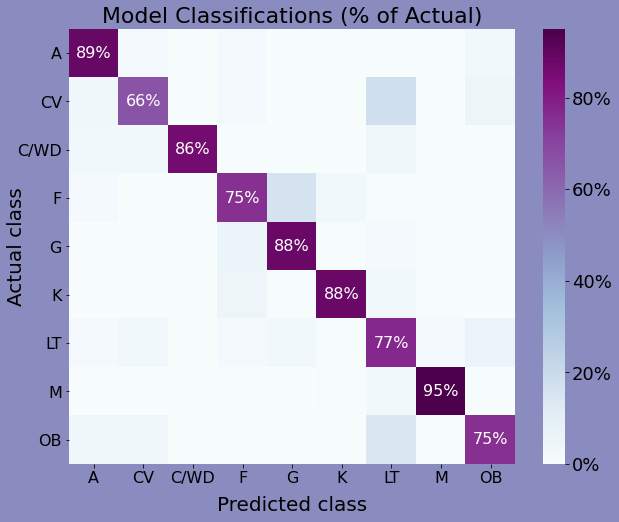

In [ ]:
plot_cm(y_test.values, test_predictions) #extra dense layers plus another dropout

In [ ]:
balanced_accuracy_score(np.argmax(y_test.values, axis=1), np.argmax(test_predictions, axis=1))

0.8262855742713223

In [ ]:
balanced_accuracy_score(np.argmax(y_test.values, axis=1), np.argmax(test_predictions, axis=1))

0.8229768997717626